In this notebook we'll look at time series properties and get a sense for how we can predict them.

First, we'll import a dataset (of CO2 data) and plot it:

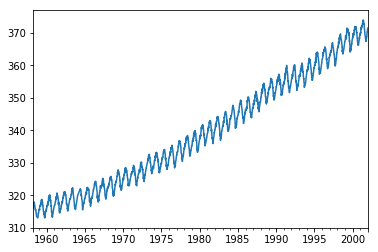

In [408]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm

dta = sm.datasets.co2.load_pandas().data
dta.co2.interpolate(inplace=True) # fix a data cleaning issue

#plot the data:
dta.co2.plot()

In [2]:
dta.co2.describe()

count    2284.000000
mean      339.652496
std        17.103561
min       313.000000
25%       323.975000
50%       337.700000
75%       354.500000
max       373.900000
Name: co2, dtype: float64

We'll use a statsmodels library function to give the time-series decomposition:

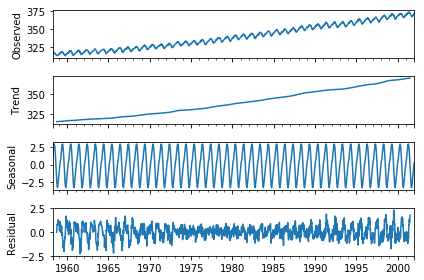

In [3]:
# plot the decomposition:
res = sm.tsa.seasonal_decompose(dta.co2)
resplot = res.plot()

Fit a linear regression to the trendline and display the parameters and goodness of fit.

In [391]:
data = sm.add_constant(res.trend)
data = data[dta.co2.isnull()!=True] # filter out missing values

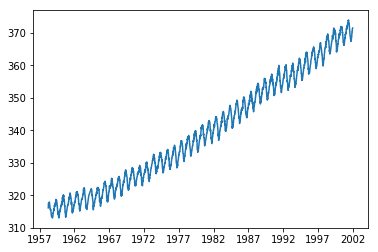

In [392]:
plt.plot(dta.co2)

In [548]:
x = [i.year for i in  dta.index] # year 
x = sm.add_constant(x)
x

array([[  1.00000000e+00,   1.95800000e+03],
       [  1.00000000e+00,   1.95800000e+03],
       [  1.00000000e+00,   1.95800000e+03],
       ..., 
       [  1.00000000e+00,   2.00100000e+03],
       [  1.00000000e+00,   2.00100000e+03],
       [  1.00000000e+00,   2.00100000e+03]])

In [542]:
y = dta.co2.values

In [543]:
y  = y.reshape(-1,1)

In [544]:
y

array([[ 316.1],
       [ 317.3],
       [ 317.6],
       ..., 
       [ 371.2],
       [ 371.3],
       [ 371.5]])

In [545]:
model = sm.OLS(endog=y,exog=x)
results = model.fit()

In [546]:
results.params # intercept and slope

array([ -2.30774459e+03,   1.33732947e+00])

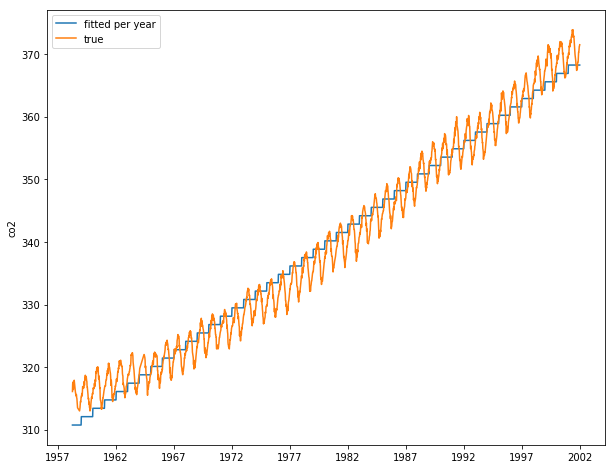

In [547]:
plt.figure(figsize=(10,8))
plt.plot(dta.index,results.fittedvalues,label='fitted per year')
plt.plot(dta.index,dta.co2.values,label='true')
plt.legend()
plt.ylabel('co2')

In [387]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.994e+05
Date:                Thu, 06 Jul 2017   Prob (F-statistic):               0.00
Time:                        11:36:26   Log-Likelihood:                -4416.4
No. Observations:                2232   AIC:                             8837.
Df Residuals:                    2230   BIC:                             8848.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        310.9222      0.074   4195.925      0.000     310.777     311.068
x1             0.0257   5.75e-05    446.529      0.000       0.026       0.026
==============================================================================
Omnibus:                      173.638   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.808
Skew:                           0.650   Prob(JB):                     9.02e-40
Kurtosis:                       2.505   Cond. No.                     2.58e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now, repeat the above decomposition and linear model fitting with only the first five years of data. (You may have to look up how to manipulate pandas data to do this.)

Plot this new trendline (based on less data) in the range 1960 - 2002, and compute the error compared to the full trend. Does your new trend model make adequate predictions? What does this imply about how much data we need to make good predictions?


In [489]:
five_yrs = datetime.datetime(1963,3,25)

In [557]:
five_years_data = dta[dta.index<five_yrs]
everything_else_data = dta[dta.index>=five_yrs]

In [491]:
X_five = [i.year for i in five_years_data.index]
X_five = sm.add_constant(X_five)

In [492]:
y_five = five_years_data .co2

In [493]:
model_five = sm.OLS(y_five,X_five).fit()


In [517]:
model_five .params

const   -1273.514982
x1          0.811389
dtype: float64

In [549]:
len(five_years_data)

261

In [558]:
predictions_five = [i for i in np.linspace(1960,2002,len(everything_else_data))]
predictions_five = sm.add_constant(predictions_five)

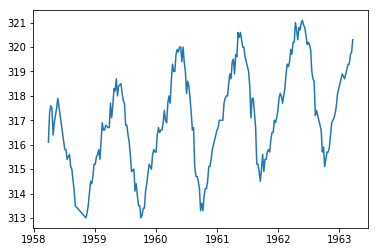

In [552]:
plt.plot(five_years_data)

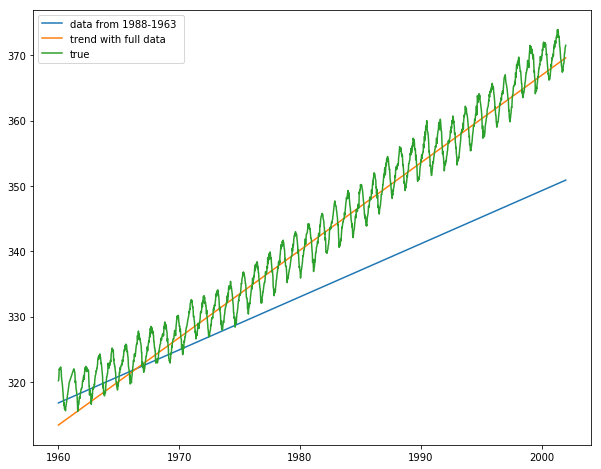

In [561]:
plt.figure(figsize=(10,8))
plt.plot([i for i in np.linspace(1960,2002,len(everything_else_data))],model_five.predict(predictions_five),label='data from 1988-1963 ')
plt.plot([i for i in np.linspace(1960,2002,len(everything_else_data))],results.predict(predictions_five), label='trend with full data')
plt.plot([i for i in np.linspace(1960,2002,len(everything_else_data))],everything_else_data.co2 ,label='true')
plt.legend();

- The new trend model does NOT make accurate predictions. We need a lot of data to make accurate predictions

- Error, difference between true and predict for each time step

In [566]:
print(f"Error for only five years of data is {sum(abs(everything_else_data.co2 \
    - model_five.predict(predictions_five)).values)}")

Error for only five years of data is 17868.623780358263


In [567]:
print(f"Error for ALL  data is {sum(abs(everything_else_data.co2 \
    - results.predict(predictions_five)).values)}")

Error for ALL  data is 4501.626798407098


Examine the seasonal component. Try to fit it with a linear model based on `t`.

In [572]:
y_seasonal = res.seasonal

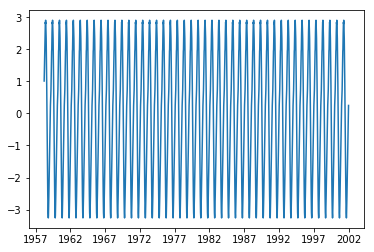

In [573]:
plt.plot(y_seasonal)

In [576]:
X_seasonal = [i.year for i in y_seasonal.index]
X_seasonal = sm.add_constant(X_seasonal)

In [577]:
model_seasonal = sm.OLS(y_seasonal,X_seasonal).fit()

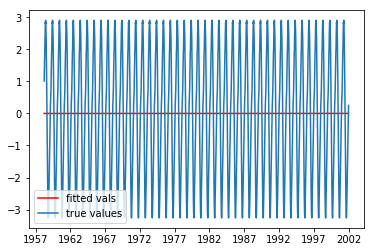

In [586]:
plt.plot(model_seasonal.fittedvalues,label='fitted vals',color='r')
plt.plot(y_seasonal,label='true values')
plt.legend();

If the seasonal component was a sawtooth, how would you fit that? (This is intended to get you thinking about the underlying functions you'll be fitting later.)

- In order to fit a sawtooth, you could fit a piecewise linear function. 
- You could also fit splines